In [ ]:
!pip install numpy pandas torch scikit-learn

## Imports

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/CSCI535/HW4'
os.chdir(PATH)

In [ ]:
df = pd.read_csv(os.path.join(PATH, 'dataset.csv'))
print(df.columns.str.strip())

Index(['file_name_list', 'speakers', 'visual_features', 'acoustic_features',
       'lexical_features', 'emotion_labels'],
      dtype='object')


In [ ]:
df.head()

,file_name_list,speakers,visual_features,acoustic_features,lexical_features,emotion_labels
0,Ses01F_impro01_F001,F01,/features/visual_features/Session1/Ses01F_impr...,/features/acoustic_features/Session1/Ses01F_im...,/features/lexical_features/Session1/Ses01F_imp...,3
1,Ses01F_impro01_M011,M01,/features/visual_features/Session1/Ses01F_impr...,/features/acoustic_features/Session1/Ses01F_im...,/features/lexical_features/Session1/Ses01F_imp...,0
2,Ses01F_impro02_F002,F01,/features/visual_features/Session1/Ses01F_impr...,/features/acoustic_features/Session1/Ses01F_im...,/features/lexical_features/Session1/Ses01F_imp...,1
3,Ses01F_impro02_F003,F01,/features/visual_features/Session1/Ses01F_impr...,/features/acoustic_features/Session1/Ses01F_im...,/features/lexical_features/Session1/Ses01F_imp...,3
4,Ses01F_impro02_F004,F01,/features/visual_features/Session1/Ses01F_impr...,/features/acoustic_features/Session1/Ses01F_im...,/features/lexical_features/Session1/Ses01F_imp...,1


## TASK



#### 1. You can use your preferred pooling methods (e.g., max pooling or mean pooling) for reducing the temporaldimension of the audio and visual sequences, or use your preferred temporal modeling (e.g., RNN, GRU,LSTM) to obtain feature vectors per data point. There’s no requirement for hyperparameters (e.g., learningrate, batch size, and weight decay) or model architecture. Perform a 4-class emotion classification using yourpreferred classifier with the obtained feature vectors. Report your classification results on individual modalities(vision, speech, and text) using the F1-micro metric on a 5-fold subject-independent cross-validation.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
## DataLoader
class MultimodalFeatureLoader:
    def __init__(self, zip_path, csv_path):
        self.zip_path = zip_path
        self.csv_path = csv_path
        self.extraction_dir = os.path.splitext(zip_path)[0]
        os.makedirs(self.extraction_dir, exist_ok=True)
        self._extract_features()
        self.dataset_df = pd.read_csv(csv_path)

    def _extract_features(self):
        if not os.listdir(self.extraction_dir):
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                zip_ref.extractall(".")
            print(f"Features extracted to {self.extraction_dir}")

    def _safe_load_numpy(self, file_path):
        try:
            if not os.path.exists(file_path):
                print(f"Warning: File not found - {file_path}")
                return None
            return np.load(file_path)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None

    def _temporal_pooling(self, features):
        if features is None or features.size == 0:
            return None
        if method == 'mean':
            return np.mean(features, axis=0)
        else:
            raise ValueError("Unsupported pooling method")

    def load_features(self):
        features = {
            'visual': [],
            'acoustic': [],
            'lexical': [],
            'labels': [],
            'speakers': []
        }
        base_dir = '/content/drive/MyDrive/CSCI535/HW4/features'
        # Process each row in the dataset
        for _, row in self.dataset_df.iterrows():

            visual_path = os.path.join(self.extraction_dir, row['visual_features'].replace('/features', base_dir))
            acoustic_path = os.path.join(self.extraction_dir, row['acoustic_features'].replace('/features',base_dir))
            lexical_path = os.path.join(self.extraction_dir, row['lexical_features'].replace('/features',base_dir))

            visual_feat = self._safe_load_numpy(visual_path)
            acoustic_feat = self._safe_load_numpy(acoustic_path)
            lexical_feat = self._safe_load_numpy(lexical_path)

            '''I'm using Mean pooling for reducing temporal dimensions'''
            '''Also, tried with Max but found this to be better'''
            visual_pooled = self._temporal_pooling(visual_feat)
            acoustic_pooled = self._temporal_pooling(acoustic_feat)

            if visual_pooled is not None:
                features['visual'].append(visual_pooled)
                features['acoustic'].append(acoustic_pooled)
                features['lexical'].append(lexical_feat)
                features['labels'].append(row['emotion_labels'])
                features['speakers'].append(row['speakers'])

        # Covert into numpy arrays
        for key in features:
            features[key] = np.array(features[key])

        return features

In [ ]:
# Paths (adjust to your specific file locations)
zip_path = os.path.join(PATH, 'features.zip')
csv_path = os.path.join(PATH,'dataset.csv')
print(zip_path)
print(csv_path )

/content/drive/MyDrive/CSCI535/HW4/features.zip
/content/drive/MyDrive/CSCI535/HW4/dataset.csv


In [ ]:
  # Initialize feature loader
loader = MultimodalFeatureLoader(zip_path, csv_path)

In [ ]:
  # # Load features
dataset_features = loader.load_features()

  # # Display feature information
print("Visual Features Shape:", dataset_features['visual'].shape)
print("Acoustic Features Shape:", dataset_features['acoustic'].shape)
print("Lexical Features Shape:", dataset_features['lexical'].shape)
print("Labels Shape:", dataset_features['labels'].shape)

Visual Features Shape: (1336, 2048)
Acoustic Features Shape: (1336, 128)
Lexical Features Shape: (1336, 768)
Labels Shape: (1336,)


#### 2. Describe the model architecture and hyperparameters you used for task 1 in a few sentences.

- For task 1, my implementation included:

  * A three-layer neural network with ReLU activations, using hidden layers of 128 and 64 neurons.
  * Mean pooling for temporal reduction of visual and acoustic features.



In [ ]:
class ModalityClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=4):
        super(ModalityClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # Depends of modality of each input_dim
            nn.ReLU(), # Activation func
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

### Train

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device='cuda'):
    model.to(device)
    best_val_f1 = 0.0
    best_model_state = None
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_preds = []
        val_true = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_true, val_preds, average='micro') # Using F1-micro
        # Save best model based on validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}')

    model.load_state_dict(best_model_state)
    return model, val_preds, val_true

### CV

In [ ]:
def cross_validation(features, modality_name, input_dim, speaker_ids, device='cuda'):

    unique_speakers = np.unique(speaker_ids)
    num_folds = 5 # 5-fold subject-independent cross-validation.
    speaker_groups = np.array_split(unique_speakers, num_folds)

    f1_scores = []
    conf_matrices = []
    all_preds = []
    all_true = []

    batch_size = 32
    learning_rate = 0.001
    num_epochs = 50
    for fold, test_speakers in enumerate(speaker_groups):
        print(f"\nFold {fold+1}/{num_folds} - Testing speakers: {test_speakers}")
        test_mask = np.isin(speaker_ids, test_speakers)
        train_mask = ~test_mask
        X_train, X_test = features[train_mask], features[test_mask]
        y_train, y_test = dataset_features['labels'][train_mask], dataset_features['labels'][test_mask]

        # Normalize features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                     torch.tensor(y_train, dtype=torch.long))
        test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                    torch.tensor(y_test, dtype=torch.long))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


        model = ModalityClassifier(input_dim=input_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        model, val_preds, val_true = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)


        fold_f1 = f1_score(val_true, val_preds, average='micro')
        fold_conf_matrix = confusion_matrix(val_true, val_preds)

        f1_scores.append(fold_f1)
        conf_matrices.append(fold_conf_matrix)
        all_preds.extend(val_preds)
        all_true.extend(val_true)

        print(f"Fold {fold+1} - F1 Score: {fold_f1:.4f}")
        print(classification_report(val_true, val_preds))


    overall_f1 = f1_score(all_true, all_preds, average='micro')
    print(f"\n{modality_name} - Overall F1 Score: {overall_f1:.4f}")
    print(f"Individual fold F1 scores: {[f'{f:.4f}' for f in f1_scores]}")
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

    return f1_scores, conf_matrices


In [ ]:
def confusion_matrices(conf_matrices, class_names, modality):
    num_folds = len(conf_matrices)
    fig, axes = plt.subplots(1, num_folds, figsize=(20, 4))

    for i, conf_matrix in enumerate(conf_matrices):
        # Normalize confusion matrix
        conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        ax = axes[i]
        sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_title(f'Fold {i+1}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    plt.tight_layout()
    plt.suptitle(f'Confusion Matrices - {modality}', y=1.05)


    plt.show()

### Unimodal Classification


=== Visual Modality ===

Fold 1/5 - Testing speakers: ['F01' 'F02']
Epoch 5/20, Train Loss: 0.2487, Val F1: 0.4157
Epoch 10/20, Train Loss: 0.0228, Val F1: 0.4082
Epoch 15/20, Train Loss: 0.0160, Val F1: 0.4082
Epoch 20/20, Train Loss: 0.0153, Val F1: 0.4007
Fold 1 - F1 Score: 0.4007
              precision    recall  f1-score   support

           0       0.47      0.47      0.47        72
           1       0.48      0.34      0.40        64
           2       0.27      0.23      0.25        47
           3       0.37      0.48      0.42        84

    accuracy                           0.40       267
   macro avg       0.40      0.38      0.38       267
weighted avg       0.41      0.40      0.40       267


Fold 2/5 - Testing speakers: ['F03' 'F04']
Epoch 5/20, Train Loss: 0.2122, Val F1: 0.3675
Epoch 10/20, Train Loss: 0.0226, Val F1: 0.3547
Epoch 15/20, Train Loss: 0.0157, Val F1: 0.3632
Epoch 20/20, Train Loss: 0.0136, Val F1: 0.3675
Fold 2 - F1 Score: 0.3675
              prec

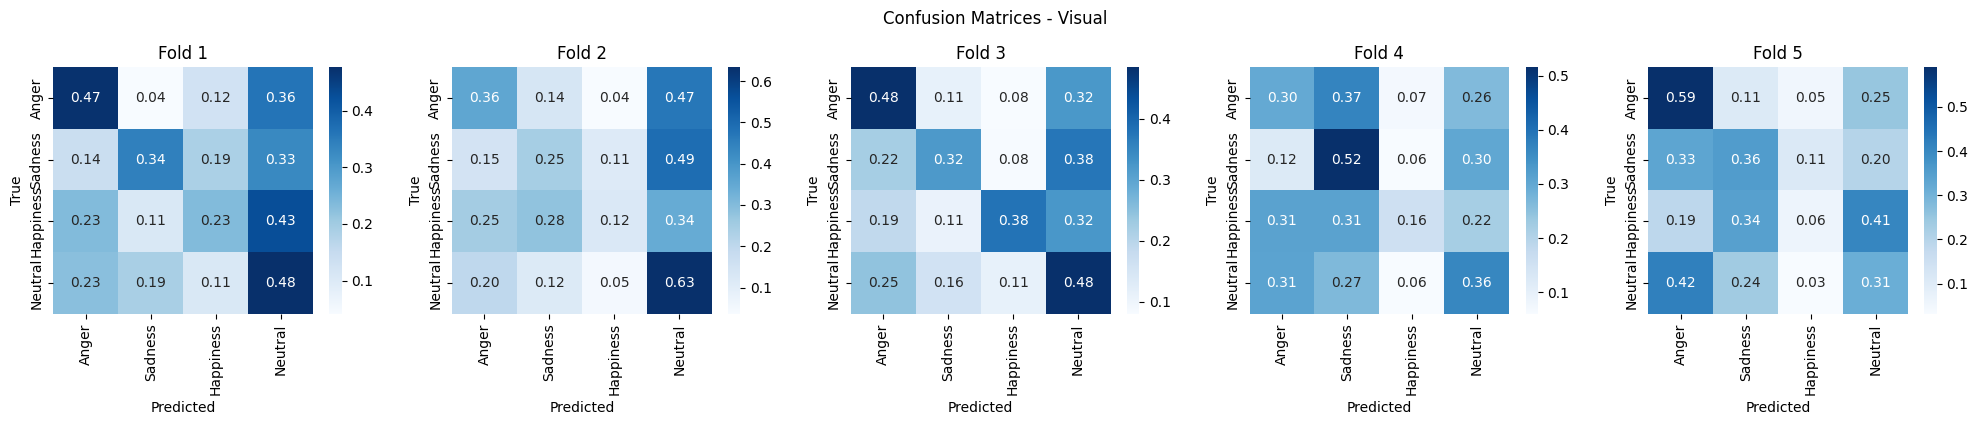

In [ ]:
    class_names = ['Anger', 'Sadness', 'Happiness', 'Neutral']
    print("\n=== Visual Modality ===")
    visual_f1_scores, visual_conf_matrices = cross_validation(
        dataset_features['visual'],
        "Visual",
        dataset_features['visual'].shape[1],
        dataset_features['speakers'],
        device
    )
    confusion_matrices(visual_conf_matrices, class_names, "Visual")

#### Key Observations:
* Performance fluctuates across different speaker pairs for visual features, suggesting variability in the model's ability to generalize (seems like overfitting)
* P,R for individual classes shows inconsistencies could be due to class imbalances in the dataset


=== Acoustic Modality ===

Fold 1/5 - Testing speakers: ['F01' 'F02']
Epoch 5/20, Train Loss: 0.9225, Val F1: 0.5243
Epoch 10/20, Train Loss: 0.7619, Val F1: 0.4981
Epoch 15/20, Train Loss: 0.6203, Val F1: 0.4981
Epoch 20/20, Train Loss: 0.4902, Val F1: 0.5318
Fold 1 - F1 Score: 0.5318
              precision    recall  f1-score   support

           0       0.68      0.64      0.66        72
           1       0.55      0.52      0.53        64
           2       0.39      0.15      0.22        47
           3       0.46      0.67      0.55        84

    accuracy                           0.53       267
   macro avg       0.52      0.49      0.49       267
weighted avg       0.53      0.53      0.51       267


Fold 2/5 - Testing speakers: ['F03' 'F04']
Epoch 5/20, Train Loss: 0.9524, Val F1: 0.4786
Epoch 10/20, Train Loss: 0.7966, Val F1: 0.4786
Epoch 15/20, Train Loss: 0.6369, Val F1: 0.4573
Epoch 20/20, Train Loss: 0.4951, Val F1: 0.4701
Fold 2 - F1 Score: 0.4701
              pr

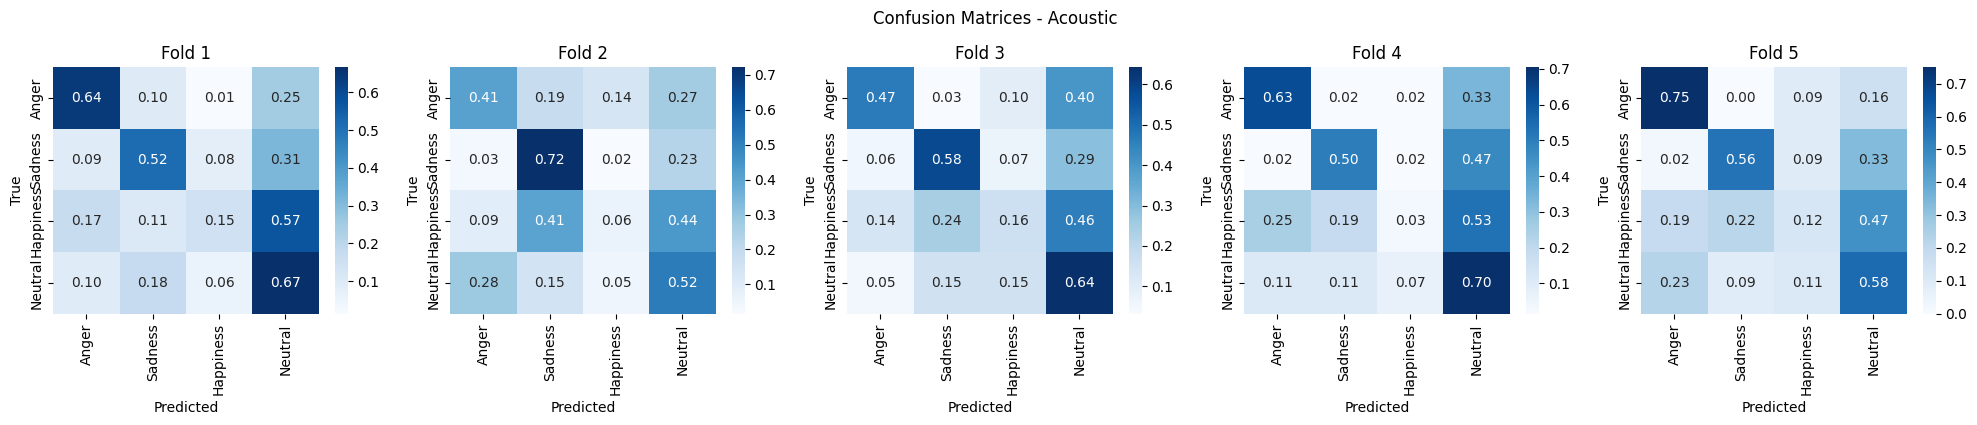

In [ ]:
print("\n=== Acoustic Modality ===")
acoustic_f1_scores, acoustic_conf_matrices = cross_validation(
    dataset_features['acoustic'],
    "Acoustic",
    dataset_features['acoustic'].shape[1],
    dataset_features['speakers'],
    device
)
confusion_matrices(acoustic_conf_matrices, class_names, "Acoustic")



=== Lexical Modality ===

Fold 1/5 - Testing speakers: ['F01' 'F02']
Epoch 5/20, Train Loss: 0.4625, Val F1: 0.5843
Epoch 10/20, Train Loss: 0.1181, Val F1: 0.5918
Epoch 15/20, Train Loss: 0.0721, Val F1: 0.6105
Epoch 20/20, Train Loss: 0.0646, Val F1: 0.6142
Fold 1 - F1 Score: 0.6142
              precision    recall  f1-score   support

           0       0.73      0.76      0.75        72
           1       0.67      0.52      0.58        64
           2       0.63      0.47      0.54        47
           3       0.50      0.64      0.56        84

    accuracy                           0.61       267
   macro avg       0.63      0.60      0.61       267
weighted avg       0.63      0.61      0.61       267


Fold 2/5 - Testing speakers: ['F03' 'F04']
Epoch 5/20, Train Loss: 0.4819, Val F1: 0.6197
Epoch 10/20, Train Loss: 0.1247, Val F1: 0.5983
Epoch 15/20, Train Loss: 0.0837, Val F1: 0.6410
Epoch 20/20, Train Loss: 0.0674, Val F1: 0.6368
Fold 2 - F1 Score: 0.6368
              pre

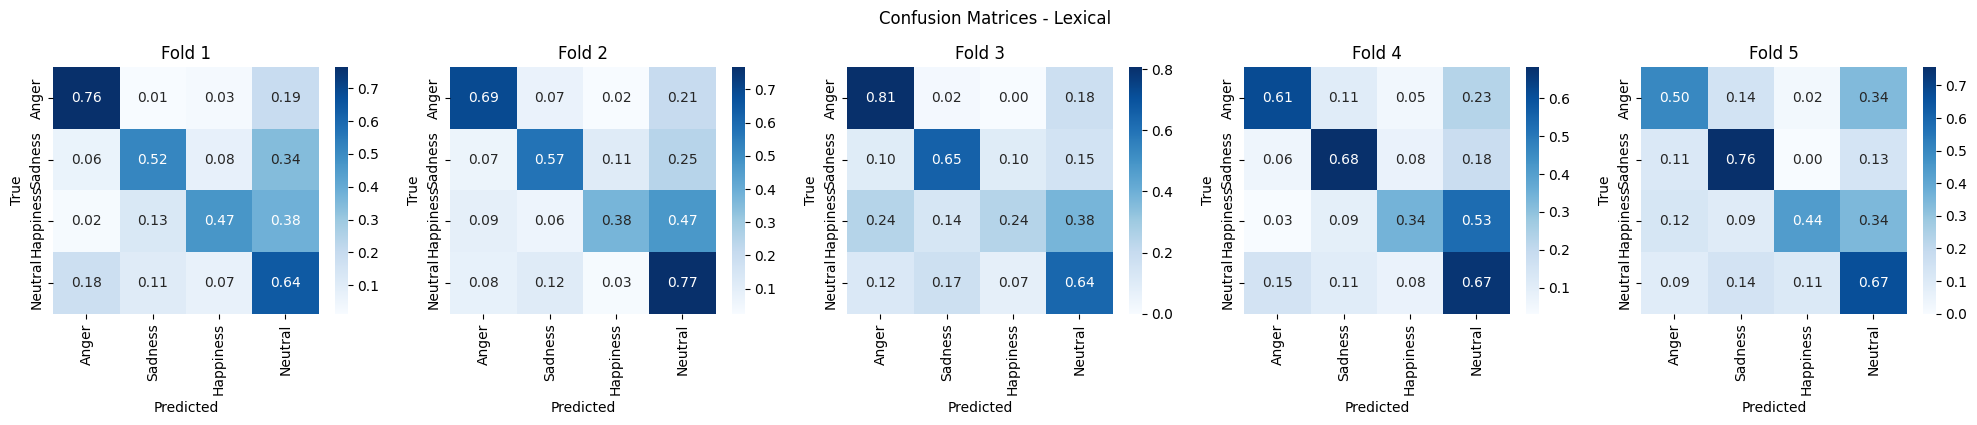

In [ ]:
print("\n=== Lexical Modality ===")
lexical_f1_scores, lexical_conf_matrices = cross_validation(
      dataset_features['lexical'],
      "Lexical",
      dataset_features['lexical'].shape[1],
      dataset_features['speakers'],
      device
  )
confusion_matrices(lexical_conf_matrices, class_names, "Lexical")

#### Key Observations:

1. For Acoustic:
  * The F-1 score and the class-wise accuracy are comparatively better
  * But the training loss seems decreasing, but the no drastic change in F-1 score (shows models struggles to generalize)

2. For Lexical:
 * Lexical features does outperform the other two providing high F-1 score and more stable



Next, we will explore how the multimodal approach, through early and late fusion, can impact the F-1 score and class-wise accuracy.

### MultiModal

- Ref: https://medium.com/@raj.pulapakura/multimodal-models-and-fusion-a-complete-guide-225ca91f6861
- Ref: https://dev-discuss.pytorch.org/t/nnc-walkthrough-how-pytorch-ops-get-fused/125

#### 4. Use both early fusion (concatenate features from different modalities) and late fusion (majority vote over theoutputs of the unimodal models) to obtain multimodal classification results. Report and compare the resultsfor both fusion techniques. (Same as task 1, using the F1-micro metric on a 5-fold subject-independentcross-validation.)

Key points:
- I have fused(combined) features from the visual,acoustic and lexical modalities before feeding them into the network
- The ```input_layer``` takes the concat features as ```combined_dim```
- Later the model processes them through a series of layers, and outputs a prediction for the emotion class.



In [ ]:
class EarlyFusionModel(nn.Module):
    def __init__(self, visual_dim, acoustic_dim, lexical_dim, hidden_dim=256, num_classes=4):
        super(EarlyFusionModel, self).__init__()
        self.combined_dim = visual_dim + acoustic_dim + lexical_dim

        self.model = nn.Sequential(
            nn.Linear(self.combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
def early_fusion_cv(visual_features, acoustic_features, lexical_features,
                                 speaker_ids, device='cuda'):
    '''Feature-level fusion where we fuse before we train the model'''

    unique_speakers = np.unique(speaker_ids)
    num_folds = 5
    speaker_groups = np.array_split(unique_speakers, num_folds)

    f1_scores = []
    conf_matrices = []
    all_preds = []
    all_true = []
    batch_size = 32
    learning_rate = 0.0005
    num_epochs = 50

    # Input dimensions for each modality
    visual_dim = visual_features.shape[1]
    acoustic_dim = acoustic_features.shape[1]
    lexical_dim = lexical_features.shape[1]

    for fold, test_speakers in enumerate(speaker_groups):
        print(f"\nFold {fold+1}/{num_folds} - Testing speakers: {test_speakers}")

        # Create train/test split based on speakers
        test_mask = np.isin(speaker_ids, test_speakers)
        train_mask = ~test_mask

        # Split data for each modality
        X_visual_train, X_visual_test = visual_features[train_mask], visual_features[test_mask]
        X_acoustic_train, X_acoustic_test = acoustic_features[train_mask], acoustic_features[test_mask]
        X_lexical_train, X_lexical_test = lexical_features[train_mask], lexical_features[test_mask]
        y_train, y_test = dataset_features['labels'][train_mask], dataset_features['labels'][test_mask]

        # Normalize features for each modality use StandardScaler
        visual_scaler = StandardScaler()
        acoustic_scaler = StandardScaler()
        lexical_scaler = StandardScaler()

        X_visual_train = visual_scaler.fit_transform(X_visual_train)
        X_visual_test = visual_scaler.transform(X_visual_test)

        X_acoustic_train = acoustic_scaler.fit_transform(X_acoustic_train)
        X_acoustic_test = acoustic_scaler.transform(X_acoustic_test)

        X_lexical_train = lexical_scaler.fit_transform(X_lexical_train)
        X_lexical_test = lexical_scaler.transform(X_lexical_test)

        # early fusion --> Concatenation
        # Normalising is needed
        X_train = np.hstack((X_visual_train, X_acoustic_train, X_lexical_train))
        X_test = np.hstack((X_visual_test, X_acoustic_test, X_lexical_test))

        # Create PyTorch datasets and loaders
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                     torch.tensor(y_train, dtype=torch.long))
        test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                    torch.tensor(y_test, dtype=torch.long))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




        model = EarlyFusionModel(visual_dim, acoustic_dim, lexical_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        model, val_preds, val_true = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

        fold_f1 = f1_score(val_true, val_preds, average='micro')
        fold_conf_matrix = confusion_matrix(val_true, val_preds)
        f1_scores.append(fold_f1)
        conf_matrices.append(fold_conf_matrix)
        all_preds.extend(val_preds)
        all_true.extend(val_true)
        print(f"Fold {fold+1} - F1 Score: {fold_f1:.4f}")
        print(classification_report(val_true, val_preds))



    overall_f1 = f1_score(all_true, all_preds, average='micro')
    print(f"\nEarly Fusion - Overall F1 Score: {overall_f1:.4f}")
    print(f"Individual fold F1 scores: {[f'{f:.4f}' for f in f1_scores]}")
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

    return f1_scores, conf_matrices



=== Early Fusion ===

Fold 1/5 - Testing speakers: ['F01' 'F02']
Epoch 5/50, Train Loss: 0.0355, Val F1: 0.6255
Epoch 10/50, Train Loss: 0.0137, Val F1: 0.6367
Epoch 15/50, Train Loss: 0.0100, Val F1: 0.6292
Epoch 20/50, Train Loss: 0.0071, Val F1: 0.6330
Epoch 25/50, Train Loss: 0.0088, Val F1: 0.6367
Epoch 30/50, Train Loss: 0.0019, Val F1: 0.6367
Epoch 35/50, Train Loss: 0.0006, Val F1: 0.6330
Epoch 40/50, Train Loss: 0.0004, Val F1: 0.6330
Epoch 45/50, Train Loss: 0.0002, Val F1: 0.6367
Epoch 50/50, Train Loss: 0.0002, Val F1: 0.6330
Fold 1 - F1 Score: 0.6330
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        72
           1       0.68      0.69      0.68        64
           2       0.54      0.30      0.38        47
           3       0.53      0.64      0.58        84

    accuracy                           0.63       267
   macro avg       0.63      0.60      0.61       267
weighted avg       0.63      0.63      0.62      

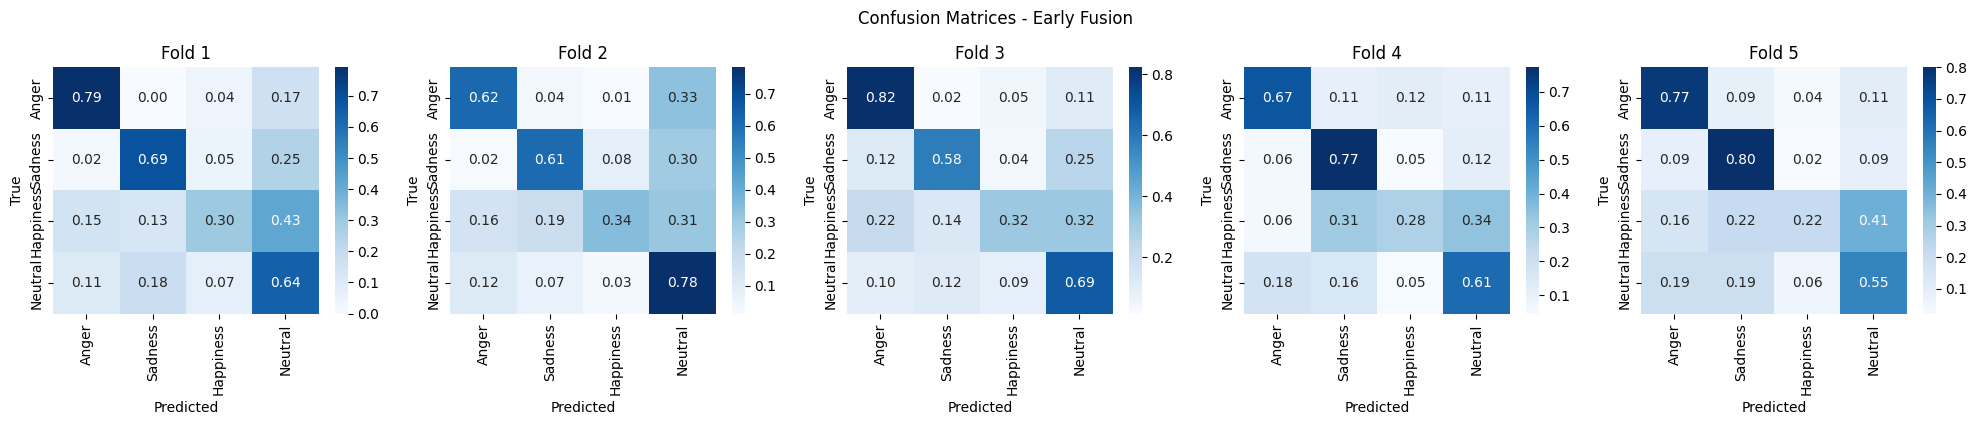

In [ ]:
print("\n=== Early Fusion ===")
early_fusion_f1_scores, early_fusion_conf_matrices = early_fusion_cv(
    dataset_features['visual'],
    dataset_features['acoustic'],
    dataset_features['lexical'],
    dataset_features['speakers'],
    device
)
plot_confusion_matrices(early_fusion_conf_matrices, class_names, "Early Fusion")

In [ ]:
def late_fusion_cv(visual_features, acoustic_features, lexical_features,
                               speaker_ids, device='cuda'):
    '''Decision-level (We do major voting after we train and make predictions)'''
    unique_speakers = np.unique(speaker_ids)
    num_folds = 5
    speaker_groups = np.array_split(unique_speakers, num_folds)

    f1_scores = []
    conf_matrices = []
    all_preds = []
    all_true = []

    batch_size = 32
    learning_rate = 0.001
    num_epochs = 50


    visual_dim = visual_features.shape[1]
    acoustic_dim = acoustic_features.shape[1]
    lexical_dim = lexical_features.shape[1]
    for fold, test_speakers in enumerate(speaker_groups):
        print(f"\nFold {fold+1}/{num_folds} - Testing speakers: {test_speakers}")
        test_mask = np.isin(speaker_ids, test_speakers)
        train_mask = ~test_mask

        # Split data for each modality
        X_visual_train, X_visual_test = visual_features[train_mask], visual_features[test_mask]
        X_acoustic_train, X_acoustic_test = acoustic_features[train_mask], acoustic_features[test_mask]
        X_lexical_train, X_lexical_test = lexical_features[train_mask], lexical_features[test_mask]
        y_train, y_test = dataset_features['labels'][train_mask], dataset_features['labels'][test_mask]

        # Normalize features for each modality
        visual_scaler = StandardScaler()
        acoustic_scaler = StandardScaler()
        lexical_scaler = StandardScaler()

        X_visual_train = visual_scaler.fit_transform(X_visual_train)
        X_visual_test = visual_scaler.transform(X_visual_test)

        X_acoustic_train = acoustic_scaler.fit_transform(X_acoustic_train)
        X_acoustic_test = acoustic_scaler.transform(X_acoustic_test)

        X_lexical_train = lexical_scaler.fit_transform(X_lexical_train)
        X_lexical_test = lexical_scaler.transform(X_lexical_test)

        # Create PyTorch datasets and loaders for each modality
        visual_train_dataset = TensorDataset(torch.tensor(X_visual_train, dtype=torch.float32),
                                           torch.tensor(y_train, dtype=torch.long))
        visual_test_dataset = TensorDataset(torch.tensor(X_visual_test, dtype=torch.float32),
                                          torch.tensor(y_test, dtype=torch.long))

        acoustic_train_dataset = TensorDataset(torch.tensor(X_acoustic_train, dtype=torch.float32),
                                             torch.tensor(y_train, dtype=torch.long))
        acoustic_test_dataset = TensorDataset(torch.tensor(X_acoustic_test, dtype=torch.float32),
                                            torch.tensor(y_test, dtype=torch.long))

        lexical_train_dataset = TensorDataset(torch.tensor(X_lexical_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.long))
        lexical_test_dataset = TensorDataset(torch.tensor(X_lexical_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.long))

        # Create data loaders
        visual_train_loader = DataLoader(visual_train_dataset, batch_size=batch_size, shuffle=True)
        visual_test_loader = DataLoader(visual_test_dataset, batch_size=batch_size, shuffle=False)

        acoustic_train_loader = DataLoader(acoustic_train_dataset, batch_size=batch_size, shuffle=True)
        acoustic_test_loader = DataLoader(acoustic_test_dataset, batch_size=batch_size, shuffle=False)

        lexical_train_loader = DataLoader(lexical_train_dataset, batch_size=batch_size, shuffle=True)
        lexical_test_loader = DataLoader(lexical_test_dataset, batch_size=batch_size, shuffle=False)


        # Unlike, the early fusion we train first pass through the feed forward network and later fuse
        # Train individual models for each modality

        # Visual
        visual_model = ModalityClassifier(input_dim=visual_dim)
        visual_criterion = nn.CrossEntropyLoss() # I'm using Cross-Entropy
        visual_optimizer = optim.Adam(visual_model.parameters(), lr=learning_rate, weight_decay=1e-5)

        visual_model, _, _ = train_model(visual_model, visual_train_loader, visual_test_loader,
                                     visual_criterion, visual_optimizer, num_epochs, device)


        # Remains the same of other two modals
        # Acoustic
        acoustic_model = ModalityClassifier(input_dim=acoustic_dim)
        acoustic_criterion = nn.CrossEntropyLoss()
        acoustic_optimizer = optim.Adam(acoustic_model.parameters(), lr=learning_rate, weight_decay=1e-5)

        acoustic_model, _, _ = train_model(acoustic_model, acoustic_train_loader, acoustic_test_loader,
                                       acoustic_criterion, acoustic_optimizer, num_epochs, device)

        # Lecxical
        lexical_model = ModalityClassifier(input_dim=lexical_dim)
        lexical_criterion = nn.CrossEntropyLoss()
        lexical_optimizer = optim.Adam(lexical_model.parameters(), lr=learning_rate, weight_decay=1e-5)

        lexical_model, _, _ = train_model(lexical_model, lexical_train_loader, lexical_test_loader,
                                      lexical_criterion, lexical_optimizer, num_epochs, device)

        visual_model.eval()
        acoustic_model.eval()
        lexical_model.eval()

        visual_preds = []
        acoustic_preds = []
        lexical_preds = []
        true_labels = []

        with torch.no_grad():
            # Visual predictions
            for inputs, labels in visual_test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = visual_model(inputs)
                _, preds = torch.max(outputs, 1)
                visual_preds.extend(preds.cpu().numpy())
                true_labels = labels.cpu().numpy()

            # Acoustic predictions
            acoustic_preds = []
            for inputs, labels in acoustic_test_loader:
                inputs = inputs.to(device)
                outputs = acoustic_model(inputs)
                _, preds = torch.max(outputs, 1)
                acoustic_preds.extend(preds.cpu().numpy())

            # Lexical predictions
            lexical_preds = []
            for inputs, labels in lexical_test_loader:
                inputs = inputs.to(device)
                outputs = lexical_model(inputs)
                _, preds = torch.max(outputs, 1)
                lexical_preds.extend(preds.cpu().numpy())

        # Convert predictions to numpy arrays
        visual_preds = np.array(visual_preds)
        acoustic_preds = np.array(acoustic_preds)
        lexical_preds = np.array(lexical_preds)

        # Majority voting (Late Fuse)
        stacked_preds = np.vstack([visual_preds, acoustic_preds, lexical_preds])
        majority_votes = np.apply_along_axis(
            lambda x: np.bincount(x, minlength=4).argmax(),
            axis=0,
            arr=stacked_preds
        )


        fold_f1 = f1_score(y_test, majority_votes, average='micro')
        fold_conf_matrix = confusion_matrix(y_test, majority_votes)
        f1_scores.append(fold_f1)
        conf_matrices.append(fold_conf_matrix)
        all_preds.extend(majority_votes)
        all_true.extend(y_test)

        print(f"Fold {fold+1} - F1 Score: {fold_f1:.4f}")
        print(classification_report(y_test, majority_votes))

    # Calculate overall metrics
    overall_f1 = f1_score(all_true, all_preds, average='micro')
    print(f"\nLate Fusion - Overall F1 Score: {overall_f1:.4f}")
    print(f"Individual fold F1 scores: {[f'{f:.4f}' for f in f1_scores]}")
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

    return f1_scores, conf_matrices


=== Late Fusion ===

Fold 1/5 - Testing speakers: ['F01' 'F02']
Epoch 5/50, Train Loss: 0.1114, Val F1: 0.4195
Epoch 10/50, Train Loss: 0.0177, Val F1: 0.4082
Epoch 15/50, Train Loss: 0.0142, Val F1: 0.4045
Epoch 20/50, Train Loss: 0.0139, Val F1: 0.3970
Epoch 25/50, Train Loss: 0.0135, Val F1: 0.3970
Epoch 30/50, Train Loss: 0.0133, Val F1: 0.4007
Epoch 35/50, Train Loss: 0.0128, Val F1: 0.3970
Epoch 40/50, Train Loss: 0.0123, Val F1: 0.4045
Epoch 45/50, Train Loss: 0.0124, Val F1: 0.4007
Epoch 50/50, Train Loss: 0.0126, Val F1: 0.4007
Epoch 5/50, Train Loss: 0.8372, Val F1: 0.5094
Epoch 10/50, Train Loss: 0.6003, Val F1: 0.4944
Epoch 15/50, Train Loss: 0.3631, Val F1: 0.5056
Epoch 20/50, Train Loss: 0.1850, Val F1: 0.5543
Epoch 25/50, Train Loss: 0.0835, Val F1: 0.5131
Epoch 30/50, Train Loss: 0.0345, Val F1: 0.5243
Epoch 35/50, Train Loss: 0.0166, Val F1: 0.5169
Epoch 40/50, Train Loss: 0.0102, Val F1: 0.5131
Epoch 45/50, Train Loss: 0.0067, Val F1: 0.5206
Epoch 50/50, Train Loss: 

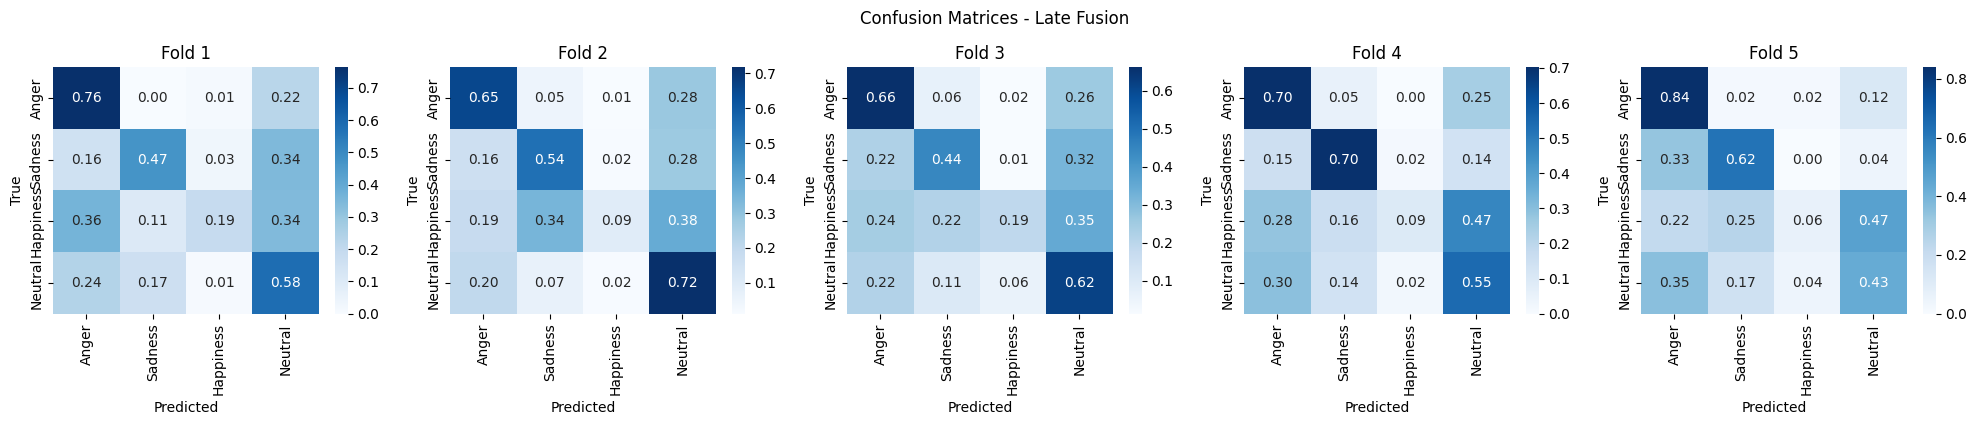

In [ ]:
print("\n=== Late Fusion ===")
late_fusion_f1_scores, late_fusion_conf_matrices = late_fusion_cv(
    dataset_features['visual'],
    dataset_features['acoustic'],
    dataset_features['lexical'],
    dataset_features['speakers'],
    device
)
plot_confusion_matrices(late_fusion_conf_matrices, class_names, "Late Fusion")

### Comparision

 #### 5. Provide an interpretation of your results from the performed unimodal and multimodal classification tasks. Which one is performing better and why?


============= Summary ================
    Modality  Mean F1  Std F1
      Visual   0.3839  0.0300
    Acoustic   0.5327  0.0336
     Lexical   0.6225  0.0094
Early Fusion   0.6256  0.0145
 Late Fusion   0.5431  0.0173


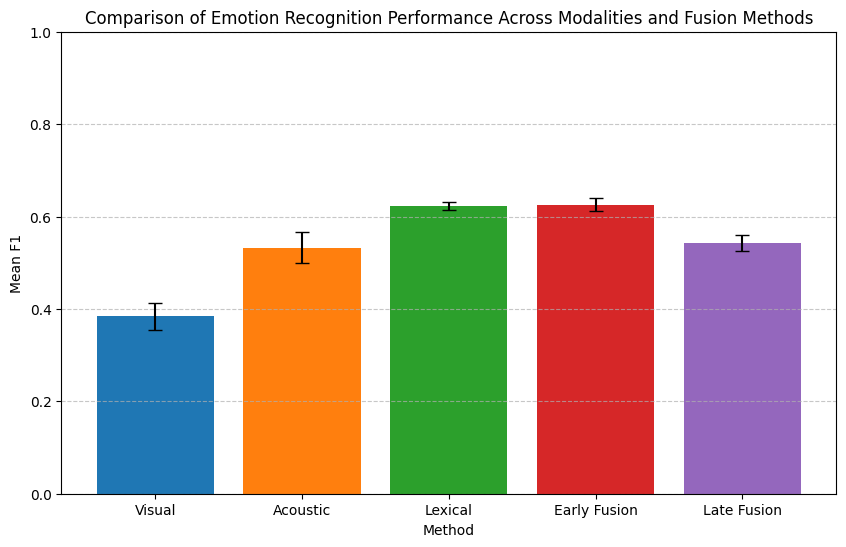

In [ ]:
    def compare_results(visual_scores, acoustic_scores, lexical_scores, early_fusion_scores, late_fusion_scores):

        visual_mean = np.mean(visual_scores)
        visual_std = np.std(visual_scores)
        acoustic_mean = np.mean(acoustic_scores)
        acoustic_std = np.std(acoustic_scores)
        lexical_mean = np.mean(lexical_scores)
        lexical_std = np.std(lexical_scores)


        # Early and late fusion
        early_fusion_mean = np.mean(early_fusion_scores)
        early_fusion_std = np.std(early_fusion_scores)
        late_fusion_mean = np.mean(late_fusion_scores)
        late_fusion_std = np.std(late_fusion_scores)

        # Summary
        summary_data = {
            'Modality': ['Visual', 'Acoustic', 'Lexical', 'Early Fusion', 'Late Fusion'],
            'Mean F1': [visual_mean, acoustic_mean, lexical_mean, early_fusion_mean, late_fusion_mean],
            'Std F1': [visual_std, acoustic_std, lexical_std, early_fusion_std, late_fusion_std]
        }
        summary_df = pd.DataFrame(summary_data)

        # Plot results
        plt.figure(figsize=(10, 6))
        bars = plt.bar(summary_df['Modality'], summary_df['Mean F1'], yerr=summary_df['Std F1'],
                       capsize=5, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
        plt.title('Comparison of Emotion Recognition Performance Across Modalities and Fusion Methods')
        plt.xlabel('Method')
        plt.ylabel('Mean F1')
        plt.ylim([0, 1])
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        print("\n============= Summary ================")
        print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    compare_results(visual_f1_scores, acoustic_f1_scores, lexical_f1_scores,
                   early_fusion_f1_scores, late_fusion_f1_scores)

Conclusion:
* The early fusion method outperforms the unimodal features and late fusion method, with a mean F1 score of 62.56%.
* Early has the higher F-1, which is likely more effective because it integrates the different modalities' features before any processing, allowing the model to capture relationships between them more effectively.
* Apparently, combining features at an earlier stage may provide a more holistic representation of the data, improved classification performance.